<a href="https://colab.research.google.com/github/ysurs/Vit/blob/main/ViT_paper_experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Basic imports

In [1]:
!pip install -q torchinfo

In [20]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchinfo import summary
from PIL import Image
from torch.utils.data import DataLoader

In [42]:
import PIL

In [3]:
import os
import zipfile

from pathlib import Path

import requests

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Getting data and storing it in folder

In [5]:
# Getting the data and returning image dataset path
# Taken as is from Daniel Bourke's Pytorch from zero to mastery

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    

    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Single image transformation

In [9]:
# transforming images to suit the needs of ViT

image_size=224

transform=transforms.Compose([transforms.Resize((image_size,image_size)),transforms.ToTensor()])



In [12]:
single_image=Image.open('/content/data/pizza_steak_sushi/train/pizza/1008844.jpg')

In [17]:

transform(single_image).shape

torch.Size([3, 224, 224])

### Creating DataLoaders

In [18]:
import os
NUM_WORKERS = os.cpu_count()

In [19]:
NUM_WORKERS

2

In [21]:
# Taken as is from Daniel Bourke's Pytorch from zero to mastery

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.
  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.
  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.
  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [22]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f3c31149340>,
 ['pizza', 'steak', 'sushi'])

### Inspecting the dataloaders

In [ ]:
for i in train_dataloader:
  print(i)
  first_batch=i
  break

In [25]:
type(first_batch)

list

In [48]:
# First image is a pizza
first_batch[1][0]

tensor(0)

In [45]:
trans=(transforms.ToPILImage()(first_batch[0][0]))

In [47]:
first_batch[0][0].shape

torch.Size([3, 224, 224])

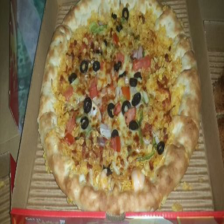

In [46]:
# This is the fist image 
trans.show()